# 性早熟预测模型（精简特征版）

**使用精简特征集（9个特征）进行模型训练**

精简特征基于医生临床经验筛选：
- LH/FSH 相关：基础LH、基础FSH、LH/FSH比值
- 骨龄相关：骨龄、骨龄与实际年龄比值
- 子宫卵巢径线/体积：子宫长宽厚体积、左右卵巢长宽厚体积

## 1. 导入必要的库

In [1]:
import os

os.environ["SCIPY_ARRAY_API"] = "1"

import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
)
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d
import xgboost as xgb
from tabpfn import TabPFNClassifier
import tabm
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import graphviz


plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

import re
import joblib


def create_missforest_imputer(random_state=825):
    """创建MissForest插补器（IterativeImputer + RandomForest）"""
    return IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=10,
            max_depth=10,
            n_jobs=-1,
            random_state=random_state,
        ),
        max_iter=10,
        random_state=random_state,
        verbose=0,
    )


if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"显存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

GPU: NVIDIA GeForce RTX 3080 Laptop GPU
显存: 16.0 GB


## 2. 设置路径和参数

In [2]:
os.makedirs("./output", exist_ok=True)
os.makedirs("../output/ml_simplified", exist_ok=True)
os.makedirs("../output/ml_simplified/models", exist_ok=True)

RANDOM_SEED = 825
np.random.seed(RANDOM_SEED)
N_JOBS = -1

print(f"随机种子: {RANDOM_SEED}")
print(f"输出目录: ../output/ml_simplified/")

随机种子: 825
输出目录: ../output/ml_simplified/


## 3. 读取精简特征数据

In [3]:
normal_data = pd.read_csv("../input/性早熟数据激发试验正常组_simplified.csv")
disease_data = pd.read_csv("../input/激发试验确诊性早熟组数据_simplified.csv")

normal_data["group"] = "N"
disease_data["group"] = "Y"

print(f"正常组: {normal_data.shape[0]} 行, {normal_data.shape[1]} 列")
print(f"早熟组: {disease_data.shape[0]} 行, {disease_data.shape[1]} 列")
print(f"\n精简特征列表:")
for col in normal_data.columns:
    if col not in ["group", "患者编号"]:
        print(f"  - {col}")

正常组: 299 行, 8 列
早熟组: 364 行, 8 列

精简特征列表:
  - 基础血清促黄体生成激素（LH）
  - 子宫长（cm）
  - 子宫厚（cm）
  - 最大卵泡直径直径
  - 卵巢体积平均值
  - LH/FSH比值


## 4. 数据类型处理和合并

In [4]:
# 不再合并数据，保持正常组和性早熟组分离
print(f"正常组: {normal_data.shape[0]} 行")
print(f"性早熟组: {disease_data.shape[0]} 行")
print(f"总样本: {normal_data.shape[0] + disease_data.shape[0]} 行")

正常组: 299 行
性早熟组: 364 行
总样本: 663 行


## 5. 查看数据基本信息

In [5]:
print("数据基本信息:")
print(f"正常组维度: {normal_data.shape}")
print(f"性早熟组维度: {disease_data.shape}")
print(f"\n正常组缺失值统计:")
missing_normal = normal_data.isnull().sum()
missing_normal = missing_normal[missing_normal > 0].sort_values(ascending=False)
if len(missing_normal) > 0:
    print(missing_normal.head(10))
print(f"\n性早熟组缺失值统计:")
missing_disease = disease_data.isnull().sum()
missing_disease = missing_disease[missing_disease > 0].sort_values(ascending=False)
if len(missing_disease) > 0:
    print(missing_disease.head(10))

数据基本信息:
正常组维度: (299, 8)
性早熟组维度: (364, 8)

正常组缺失值统计:
最大卵泡直径直径    262
子宫长（cm）     220
子宫厚（cm）     220
卵巢体积平均值     220
dtype: int64

性早熟组缺失值统计:
子宫长（cm）            296
子宫厚（cm）            296
最大卵泡直径直径           214
卵巢体积平均值            130
基础血清促黄体生成激素（LH）      3
LH/FSH比值             3
dtype: int64


## 6. 划分训练集和验证集

In [6]:
# 使用分组填补策略（与Tabm_Simplified.ipynb一致）
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in normal_data.columns if col not in exclude_cols]

print(f"使用 {len(feature_cols)} 个精简特征")
print("使用分组填补策略（MissForest方法）...")

# 分别对正常组和性早熟组进行填补
imputer_normal = create_missforest_imputer(RANDOM_SEED)
imputer_disease = create_missforest_imputer(RANDOM_SEED)

normal_features = normal_data[feature_cols].copy()
disease_features = disease_data[feature_cols].copy()

normal_imputed = pd.DataFrame(
    imputer_normal.fit_transform(normal_features), columns=feature_cols
)
disease_imputed = pd.DataFrame(
    imputer_disease.fit_transform(disease_features), columns=feature_cols
)

print(f"正常组填补完成: {normal_imputed.shape}")
print(f"性早熟组填补完成: {disease_imputed.shape}")

# 添加标签列
normal_imputed["group"] = "N"
disease_imputed["group"] = "Y"

# 合并数据
data = pd.concat([normal_imputed, disease_imputed], axis=0, ignore_index=True)
data["group"] = data["group"].astype("category")
print(f"\n合并后数据: {data.shape[0]} 行 x {data.shape[1]} 列")
print(f"分组统计:\n{data['group'].value_counts()}")

# 划分训练集和验证集
train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)
print(f"\n训练集: {train_data.shape[0]} 行, 验证集: {validation_data.shape[0]} 行")

使用 6 个精简特征
使用分组填补策略（MissForest方法）...
正常组填补完成: (299, 6)
性早熟组填补完成: (364, 6)

合并后数据: 663 行 x 7 列
分组统计:
group
Y    364
N    299
Name: count, dtype: int64

训练集: 464 行, 验证集: 199 行


## 7. 特征工程

In [7]:
X_train = train_data[feature_cols].copy()
y_train = train_data["group"].copy()
X_validation = validation_data[feature_cols].copy()
y_validation = validation_data["group"].copy()

y_train_binary = (y_train == "Y").astype(int)
y_validation_binary = (y_validation == "Y").astype(int)

print(f"使用 {len(feature_cols)} 个精简特征")
print(f"训练集正负样本: {y_train_binary.value_counts().to_dict()}")
print(f"验证集正负样本: {y_validation_binary.value_counts().to_dict()}")

使用 6 个精简特征
训练集正负样本: {1: 255, 0: 209}
验证集正负样本: {1: 109, 0: 90}


## 8. 特征概览和缺失值填补（MissForest方法）

In [8]:
print(f"特征列表 ({len(feature_cols)}个特征):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

print(f"\n训练集: {X_train.shape[0]}样本, 验证集: {X_validation.shape[0]}样本")
print(f"训练集正负样本: {y_train_binary.value_counts().to_dict()}")
print(f"验证集正负样本: {y_validation_binary.value_counts().to_dict()}")

# 数据已在分组填补阶段完成，直接使用
X_train_imputed = X_train.copy()
X_validation_imputed = X_validation.copy()

# 标准化（用于KNN/SVM/NNET/TabM等模型）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_validation_scaled = scaler.transform(X_validation_imputed)

print(f"\n数据预处理完成！")
print(f"  特征数: {X_train_imputed.shape[1]}")
print(f"  缺失值检查: {X_train_imputed.isnull().sum().sum()} (应为0)")
print(f"  标准化完成")

特征列表 (6个特征):
   1. 基础血清促黄体生成激素（LH）
   2. 子宫长（cm）
   3. 子宫厚（cm）
   4. 最大卵泡直径直径
   5. 卵巢体积平均值
   6. LH/FSH比值

训练集: 464样本, 验证集: 199样本
训练集正负样本: {1: 255, 0: 209}
验证集正负样本: {1: 109, 0: 90}

数据预处理完成！
  特征数: 6
  缺失值检查: 0 (应为0)
  标准化完成


---
# 模型训练

## 10. 设置交叉验证策略

In [9]:
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_SEED)

print(f"验证策略: 5折交叉验证 x 3次重复 = {cv_strategy.get_n_splits()}轮")
print(f"训练集: {len(X_train)}样本, 正负比={y_train_binary.value_counts().to_dict()}")
print(
    f"验证集: {len(X_validation)}样本, 正负比={y_validation_binary.value_counts().to_dict()}"
)

验证策略: 5折交叉验证 x 3次重复 = 15轮
训练集: 464样本, 正负比={1: 255, 0: 209}
验证集: 199样本, 正负比={1: 109, 0: 90}


## 11. 训练模型1: GBM (梯度提升机)

In [10]:
gbm_model = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=3,
    learning_rate=0.01,
    l2_regularization=0.5,
    min_samples_leaf=20,
    max_leaf_nodes=31,
    random_state=RANDOM_SEED,
)
gbm_model.fit(X_train_imputed, y_train_binary)

y_pred_gbm = gbm_model.predict(X_validation_imputed)
y_pred_proba_gbm = gbm_model.predict_proba(X_validation_imputed)[:, 1]
auc_gbm = roc_auc_score(y_validation_binary, y_pred_proba_gbm)
f1_gbm = f1_score(y_validation_binary, y_pred_gbm)

joblib.dump(gbm_model, "../output/ml_simplified/models/gbm_model.pkl")
print(f"GBM AUC: {auc_gbm:.4f}, F1: {f1_gbm:.4f}")

GBM AUC: 0.8892, F1: 0.8547


## 12. 训练模型2: KNN (K近邻)

In [11]:
knn_model = KNeighborsClassifier(n_neighbors=15, weights="uniform", n_jobs=N_JOBS)
knn_model.fit(X_train_scaled, y_train_binary)

y_pred_knn = knn_model.predict(X_validation_scaled)
y_pred_proba_knn = knn_model.predict_proba(X_validation_scaled)[:, 1]
auc_knn = roc_auc_score(y_validation_binary, y_pred_proba_knn)
f1_knn = f1_score(y_validation_binary, y_pred_knn)

joblib.dump(
    {
        "model": knn_model,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
        "scaler": scaler,
    },
    "../output/ml_simplified/models/knn_model.pkl",
)
print(f"KNN AUC: {auc_knn:.4f}, F1: {f1_knn:.4f}")

KNN AUC: 0.9089, F1: 0.8772


## 13. 训练模型3: Naive Bayes (朴素贝叶斯)

In [12]:
nb_model = GaussianNB()
nb_model.fit(X_train_imputed, y_train_binary)

y_pred_nb = nb_model.predict(X_validation_imputed)
y_pred_proba_nb = nb_model.predict_proba(X_validation_imputed)[:, 1]
auc_nb = roc_auc_score(y_validation_binary, y_pred_proba_nb)
f1_nb = f1_score(y_validation_binary, y_pred_nb)

joblib.dump(
    {
        "model": nb_model,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
    },
    "../output/ml_simplified/models/nb_model.pkl",
)
print(f"NB AUC: {auc_nb:.4f}, F1: {f1_nb:.4f}")

NB AUC: 0.8229, F1: 0.5375


## 14. 训练模型4: XGBoost (极限梯度提升)

In [13]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.01,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_SEED,
    tree_method="hist",
    n_jobs=N_JOBS,
)
xgb_model.fit(X_train_imputed, y_train_binary)

y_pred_xgb = xgb_model.predict(X_validation_imputed)
y_pred_proba_xgb = xgb_model.predict_proba(X_validation_imputed)[:, 1]
auc_xgb = roc_auc_score(y_validation_binary, y_pred_proba_xgb)
f1_xgb = f1_score(y_validation_binary, y_pred_xgb)

joblib.dump(xgb_model, "../output/ml_simplified/models/xgb_model.pkl")
print(f"XGB AUC: {auc_xgb:.4f}, F1: {f1_xgb:.4f}")

XGB AUC: 0.9154, F1: 0.8670


## 15. 训练模型5: Random Forest (随机森林)

In [14]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features="sqrt",
    random_state=RANDOM_SEED,
    n_jobs=N_JOBS,
)
rf_model.fit(X_train_imputed, y_train_binary)

y_pred_rf = rf_model.predict(X_validation_imputed)
y_pred_proba_rf = rf_model.predict_proba(X_validation_imputed)[:, 1]
auc_rf = roc_auc_score(y_validation_binary, y_pred_proba_rf)
f1_rf = f1_score(y_validation_binary, y_pred_rf)

joblib.dump(rf_model, "../output/ml_simplified/models/rf_model.pkl")
print(f"RF AUC: {auc_rf:.4f}, F1: {f1_rf:.4f}")

RF AUC: 0.9308, F1: 0.8841


## 16. 训练模型6: RPART (决策树)

In [15]:
rpart_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=50,
    min_samples_leaf=20,
    max_leaf_nodes=31,
    min_impurity_decrease=0.001,
    random_state=RANDOM_SEED,
)
rpart_model.fit(X_train_imputed, y_train_binary)

y_pred_rpart = rpart_model.predict(X_validation_imputed)
y_pred_proba_rpart = rpart_model.predict_proba(X_validation_imputed)[:, 1]
auc_rpart = roc_auc_score(y_validation_binary, y_pred_proba_rpart)
f1_rpart = f1_score(y_validation_binary, y_pred_rpart)

joblib.dump(
    {
        "model": rpart_model,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
    },
    "../output/ml_simplified/models/rpart_model.pkl",
)
print(f"RPART AUC: {auc_rpart:.4f}, F1: {f1_rpart:.4f}")

RPART AUC: 0.8782, F1: 0.8534


## 17. 训练模型7: GLM (逻辑回归)

In [16]:
glm_model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    penalty="l2",
    solver="lbfgs",
    random_state=RANDOM_SEED,
    n_jobs=N_JOBS,
)
glm_model.fit(X_train_imputed, y_train_binary)

y_pred_glm = glm_model.predict(X_validation_imputed)
y_pred_proba_glm = glm_model.predict_proba(X_validation_imputed)[:, 1]
auc_glm = roc_auc_score(y_validation_binary, y_pred_proba_glm)
f1_glm = f1_score(y_validation_binary, y_pred_glm)

joblib.dump(
    {
        "model": glm_model,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
    },
    "../output/ml_simplified/models/glm_model.pkl",
)
print(f"GLM AUC: {auc_glm:.4f}, F1: {f1_glm:.4f}")

GLM AUC: 0.8318, F1: 0.8000


## 18. 训练模型8: SVM (支持向量机)

In [17]:
svm_model = SVC(
    kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=RANDOM_SEED
)
svm_model.fit(X_train_scaled, y_train_binary)

y_pred_svm = svm_model.predict(X_validation_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_validation_scaled)[:, 1]
auc_svm = roc_auc_score(y_validation_binary, y_pred_proba_svm)
f1_svm = f1_score(y_validation_binary, y_pred_svm)

joblib.dump(
    {
        "model": svm_model,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
        "scaler": scaler,
    },
    "../output/ml_simplified/models/svm_model.pkl",
)
print(f"SVM AUC: {auc_svm:.4f}, F1: {f1_svm:.4f}")

SVM AUC: 0.8851, F1: 0.8658


## 19. 训练模型9: NNET (神经网络)

In [18]:
nnet_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    alpha=0.01,
    learning_rate_init=0.001,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=RANDOM_SEED,
)
nnet_model.fit(X_train_scaled, y_train_binary)

y_pred_nnet = nnet_model.predict(X_validation_scaled)
y_pred_proba_nnet = nnet_model.predict_proba(X_validation_scaled)[:, 1]
auc_nnet = roc_auc_score(y_validation_binary, y_pred_proba_nnet)
f1_nnet = f1_score(y_validation_binary, y_pred_nnet)

joblib.dump(
    {
        "model": nnet_model,
        "imputer_normal": imputer_normal,
        "imputer_disease": imputer_disease,
        "scaler": scaler,
    },
    "../output/ml_simplified/models/nnet_model.pkl",
)
print(f"NNET AUC: {auc_nnet:.4f}, F1: {f1_nnet:.4f}")

NNET AUC: 0.8695, F1: 0.8103


## 20. 导入模型10: TabM

In [19]:
print("=" * 70)
print("导入TabM最佳模型（tabms_best）")
print("=" * 70)

import rtdl_num_embeddings

tabm_best_config_path = "../output/tabm_simplified/models/tabms_best_config.pkl"
tabm_best_model_path = "../output/tabm_simplified/models/tabms_best.pt"

if os.path.exists(tabm_best_config_path) and os.path.exists(tabm_best_model_path):
    best_data = joblib.load(tabm_best_config_path)
    model_name = best_data["model_name"]
    model_config = best_data["model_config"]
    best_f1 = best_data["f1_score"]

    print(f"最佳模型: {model_name}")
    print(f"F1 Score: {best_f1:.4f}")
    print(f"模型配置:")
    for key, value in model_config.items():
        if value is not None:
            print(f"  {key}={value}")

    X_train_scaled_tabm = X_train_scaled
    X_val_scaled_tabm = X_validation_scaled
    print(f"\n使用本notebook的Scaler进行标准化")

    X_train_tensor = torch.tensor(X_train_scaled_tabm, dtype=torch.float32).cuda()
    y_train_tensor = torch.tensor(y_train_binary.values, dtype=torch.long).cuda()
    X_val_tensor = torch.tensor(X_val_scaled_tabm, dtype=torch.float32).cuda()

    print(f"训练集: {X_train_tensor.shape}, 验证集: {X_val_tensor.shape}")

    n_bins = model_config.get("n_bins", 48)
    d_embedding = model_config.get("d_embedding", 16)

    if model_config.get("periodic", False):
        num_embeddings = rtdl_num_embeddings.PeriodicEmbeddings(
            n_features=X_train_tensor.shape[1],
            d_embedding=d_embedding,
            lite=False,
        )
    else:
        num_embeddings = rtdl_num_embeddings.PiecewiseLinearEmbeddings(
            rtdl_num_embeddings.compute_bins(X_train_tensor, n_bins=n_bins),
            d_embedding=d_embedding,
            activation=False,
            version="B",
        )

    arch_type = model_config.get("arch_type", None)

    # 构建TabM.make的参数字典
    tabm_make_kwargs = {
        "n_num_features": X_train_tensor.shape[1],
        "cat_cardinalities": [],
        "d_out": 2,
        "num_embeddings": num_embeddings,
        "n_blocks": model_config.get("n_blocks", 2),
        "d_block": model_config.get("d_block", 256),
        "dropout": model_config.get("dropout", 0.0),
    }

    # 只有当arch_type不为None时才添加
    if arch_type is not None:
        tabm_make_kwargs["arch_type"] = arch_type

    tabm_model = tabm.TabM.make(**tabm_make_kwargs).cuda()

    tabm_model.load_state_dict(
        torch.load(tabm_best_model_path, map_location="cuda", weights_only=True)
    )
    tabm_model.eval()

    print(f"模型参数量: {sum(p.numel() for p in tabm_model.parameters()):,}")

    with torch.no_grad():
        val_logits = tabm_model(X_val_tensor, None)
        y_pred_proba_tabm = (
            torch.softmax(val_logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
        )
        y_pred_tabm = (y_pred_proba_tabm >= 0.5).astype(int)

    auc_tabm = roc_auc_score(y_validation_binary, y_pred_proba_tabm)
    f1_tabm = f1_score(y_validation_binary, y_pred_tabm)

    print(f"\nTabM最佳模型验证集性能: F1={f1_tabm:.4f}, AUC={auc_tabm:.4f}")
    print(f"模型来源: {tabm_best_model_path}")
else:
    print(f"警告: TabM最佳模型文件不存在，请先运行 Tabm_Simplified.ipynb")
    auc_tabm, f1_tabm = 0.0, 0.0
    y_pred_tabm = np.zeros(len(y_validation_binary))
    y_pred_proba_tabm = np.zeros(len(y_validation_binary))

print("=" * 70)

导入TabM最佳模型（tabms_best）
最佳模型: TabM-Periodic
F1 Score: 0.9115
模型配置:
  n_blocks=2
  d_block=512
  n_bins=48
  d_embedding=16
  dropout=0.1
  share_training_batches=True
  periodic=True

使用本notebook的Scaler进行标准化
训练集: torch.Size([464, 6]), 验证集: torch.Size([199, 6])
模型参数量: 438,720

TabM最佳模型验证集性能: F1=0.9115, AUC=0.9501
模型来源: ../output/tabm_simplified/models/tabms_best.pt


## 21. 导入模型11: TabPFN

In [20]:
print("=" * 70)
print("加载TabPFN模型")
print("=" * 70)

# 加载模型文件
auto_model_path = "../output/tabpfn_simplified/models/tabpfn_hpo.pkl"

if os.path.exists(auto_model_path):
    auto_data = joblib.load(auto_model_path)
    tabpfn_model = auto_data["model"]

    print(f"已加载TabPFN模型")
    print(f"模型路径: {auto_model_path}")
    print(f"模型类型: {type(tabpfn_model).__name__}")

    # 使用已填补的数据
    X_validation_tabpfn = X_validation_imputed.values

    print(f"验证集: {X_validation_tabpfn.shape}")

    # 验证集预测
    print(f"\n在验证集上进行预测...")
    y_pred_tabpfn = tabpfn_model.predict(X_validation_tabpfn)
    y_pred_proba_tabpfn = tabpfn_model.predict_proba(X_validation_tabpfn)[:, 1]

    auc_tabpfn = roc_auc_score(y_validation_binary, y_pred_proba_tabpfn)
    f1_tabpfn = f1_score(y_validation_binary, y_pred_tabpfn)

    print(f"\nTabPFN性能指标:")
    print(f"  AUC: {auc_tabpfn:.4f}")
    print(f"  F1:  {f1_tabpfn:.4f}")
else:
    print(f"警告: TabPFN模型文件不存在，请先运行 TabPFN_Simplified.ipynb")
    auc_tabpfn, f1_tabpfn = 0.0, 0.0
    y_pred_tabpfn = np.zeros(len(y_validation_binary))
    y_pred_proba_tabpfn = np.zeros(len(y_validation_binary))

print("=" * 70)

加载TabPFN模型
已加载TabPFN模型
模型路径: ../output/tabpfn_simplified/models/tabpfn_hpo.pkl
模型类型: TunedTabPFNClassifier
验证集: (199, 6)

在验证集上进行预测...

TabPFN性能指标:
  AUC: 0.9559
  F1:  0.9035


## 22. 模型性能汇总

In [21]:
models_summary = pd.DataFrame(
    {
        "模型": [
            "GBM",
            "KNN",
            "NB",
            "XGB",
            "RF",
            "RPART",
            "GLM",
            "SVM",
            "NNET",
            "TabPFN",
            "TabM",
        ],
        "AUC": [
            auc_gbm,
            auc_knn,
            auc_nb,
            auc_xgb,
            auc_rf,
            auc_rpart,
            auc_glm,
            auc_svm,
            auc_nnet,
            auc_tabpfn,
            auc_tabm,
        ],
        "F1": [
            f1_gbm,
            f1_knn,
            f1_nb,
            f1_xgb,
            f1_rf,
            f1_rpart,
            f1_glm,
            f1_svm,
            f1_nnet,
            f1_tabpfn,
            f1_tabm,
        ],
    }
).sort_values("F1", ascending=False)

best_model_name = models_summary.iloc[0]["模型"]
best_model_auc = models_summary.iloc[0]["AUC"]
best_model_f1 = models_summary.iloc[0]["F1"]

print(f"模型性能 ({len(models_summary)}个模型) - 精简特征版:")
print(models_summary.to_string(index=False))
print(
    f"\n最佳模型: {best_model_name} (F1 = {best_model_f1:.4f}, AUC = {best_model_auc:.4f})"
)

# 保存性能汇总
models_summary.to_csv(
    "../output/ml_simplified/模型性能汇总_AUC_F1.csv", index=False, encoding="utf-8-sig"
)

模型性能 (11个模型) - 精简特征版:
    模型      AUC       F1
  TabM 0.950051 0.911504
TabPFN 0.955861 0.903509
    RF 0.930785 0.884120
   KNN 0.908919 0.877193
   XGB 0.915392 0.866953
   SVM 0.885117 0.865801
   GBM 0.889195 0.854701
 RPART 0.878236 0.853448
  NNET 0.869521 0.810345
   GLM 0.831804 0.800000
    NB 0.822936 0.537500

最佳模型: TabM (F1 = 0.9115, AUC = 0.9501)


## 23. ROC曲线对比

In [22]:
print("=" * 70)
print("计算所有模型在训练集上的预测概率")
print("=" * 70)

# 1. GBM训练集预测
y_pred_proba_gbm_train = gbm_model.predict_proba(X_train_imputed)[:, 1]
auc_gbm_train = roc_auc_score(y_train_binary, y_pred_proba_gbm_train)

# 2. KNN训练集预测
y_pred_proba_knn_train = knn_model.predict_proba(X_train_scaled)[:, 1]
auc_knn_train = roc_auc_score(y_train_binary, y_pred_proba_knn_train)

# 3. NB训练集预测
y_pred_proba_nb_train = nb_model.predict_proba(X_train_imputed)[:, 1]
auc_nb_train = roc_auc_score(y_train_binary, y_pred_proba_nb_train)

# 4. XGB训练集预测
y_pred_proba_xgb_train = xgb_model.predict_proba(X_train_imputed)[:, 1]
auc_xgb_train = roc_auc_score(y_train_binary, y_pred_proba_xgb_train)

# 5. RF训练集预测
y_pred_proba_rf_train = rf_model.predict_proba(X_train_imputed)[:, 1]
auc_rf_train = roc_auc_score(y_train_binary, y_pred_proba_rf_train)

# 6. RPART训练集预测
y_pred_proba_rpart_train = rpart_model.predict_proba(X_train_imputed)[:, 1]
auc_rpart_train = roc_auc_score(y_train_binary, y_pred_proba_rpart_train)

# 7. GLM训练集预测
y_pred_proba_glm_train = glm_model.predict_proba(X_train_imputed)[:, 1]
auc_glm_train = roc_auc_score(y_train_binary, y_pred_proba_glm_train)

# 8. SVM训练集预测
y_pred_proba_svm_train = svm_model.predict_proba(X_train_scaled)[:, 1]
auc_svm_train = roc_auc_score(y_train_binary, y_pred_proba_svm_train)

# 9. NNET训练集预测
y_pred_proba_nnet_train = nnet_model.predict_proba(X_train_scaled)[:, 1]
auc_nnet_train = roc_auc_score(y_train_binary, y_pred_proba_nnet_train)

# 10. TabPFN训练集预测
if auc_tabpfn > 0:
    y_pred_proba_tabpfn_train = tabpfn_model.predict_proba(X_train_imputed.values)[:, 1]
    auc_tabpfn_train = roc_auc_score(y_train_binary, y_pred_proba_tabpfn_train)
else:
    y_pred_proba_tabpfn_train = np.zeros(len(y_train_binary))
    auc_tabpfn_train = 0.0

# 11. TabM训练集预测
if auc_tabm > 0:
    with torch.no_grad():
        train_logits = tabm_model(X_train_tensor, None)
        y_pred_proba_tabm_train = (
            torch.softmax(train_logits, dim=-1).mean(dim=1)[:, 1].cpu().numpy()
        )
    auc_tabm_train = roc_auc_score(y_train_binary, y_pred_proba_tabm_train)
else:
    y_pred_proba_tabm_train = np.zeros(len(y_train_binary))
    auc_tabm_train = 0.0

print(f"\n训练集AUC:")
print(f"  GBM:    {auc_gbm_train:.4f}")
print(f"  KNN:    {auc_knn_train:.4f}")
print(f"  NB:     {auc_nb_train:.4f}")
print(f"  XGB:    {auc_xgb_train:.4f}")
print(f"  RF:     {auc_rf_train:.4f}")
print(f"  RPART:  {auc_rpart_train:.4f}")
print(f"  GLM:    {auc_glm_train:.4f}")
print(f"  SVM:    {auc_svm_train:.4f}")
print(f"  NNET:   {auc_nnet_train:.4f}")
print(f"  TabPFN: {auc_tabpfn_train:.4f}")
print(f"  TabM:   {auc_tabm_train:.4f}")
print("\n训练集预测概率计算完成！")

计算所有模型在训练集上的预测概率

训练集AUC:
  GBM:    0.9630
  KNN:    0.9656
  NB:     0.8792
  XGB:    0.9769
  RF:     0.9851
  RPART:  0.9627
  GLM:    0.8494
  SVM:    0.9652
  NNET:   0.9155
  TabPFN: 0.9973
  TabM:   0.9969

训练集预测概率计算完成！


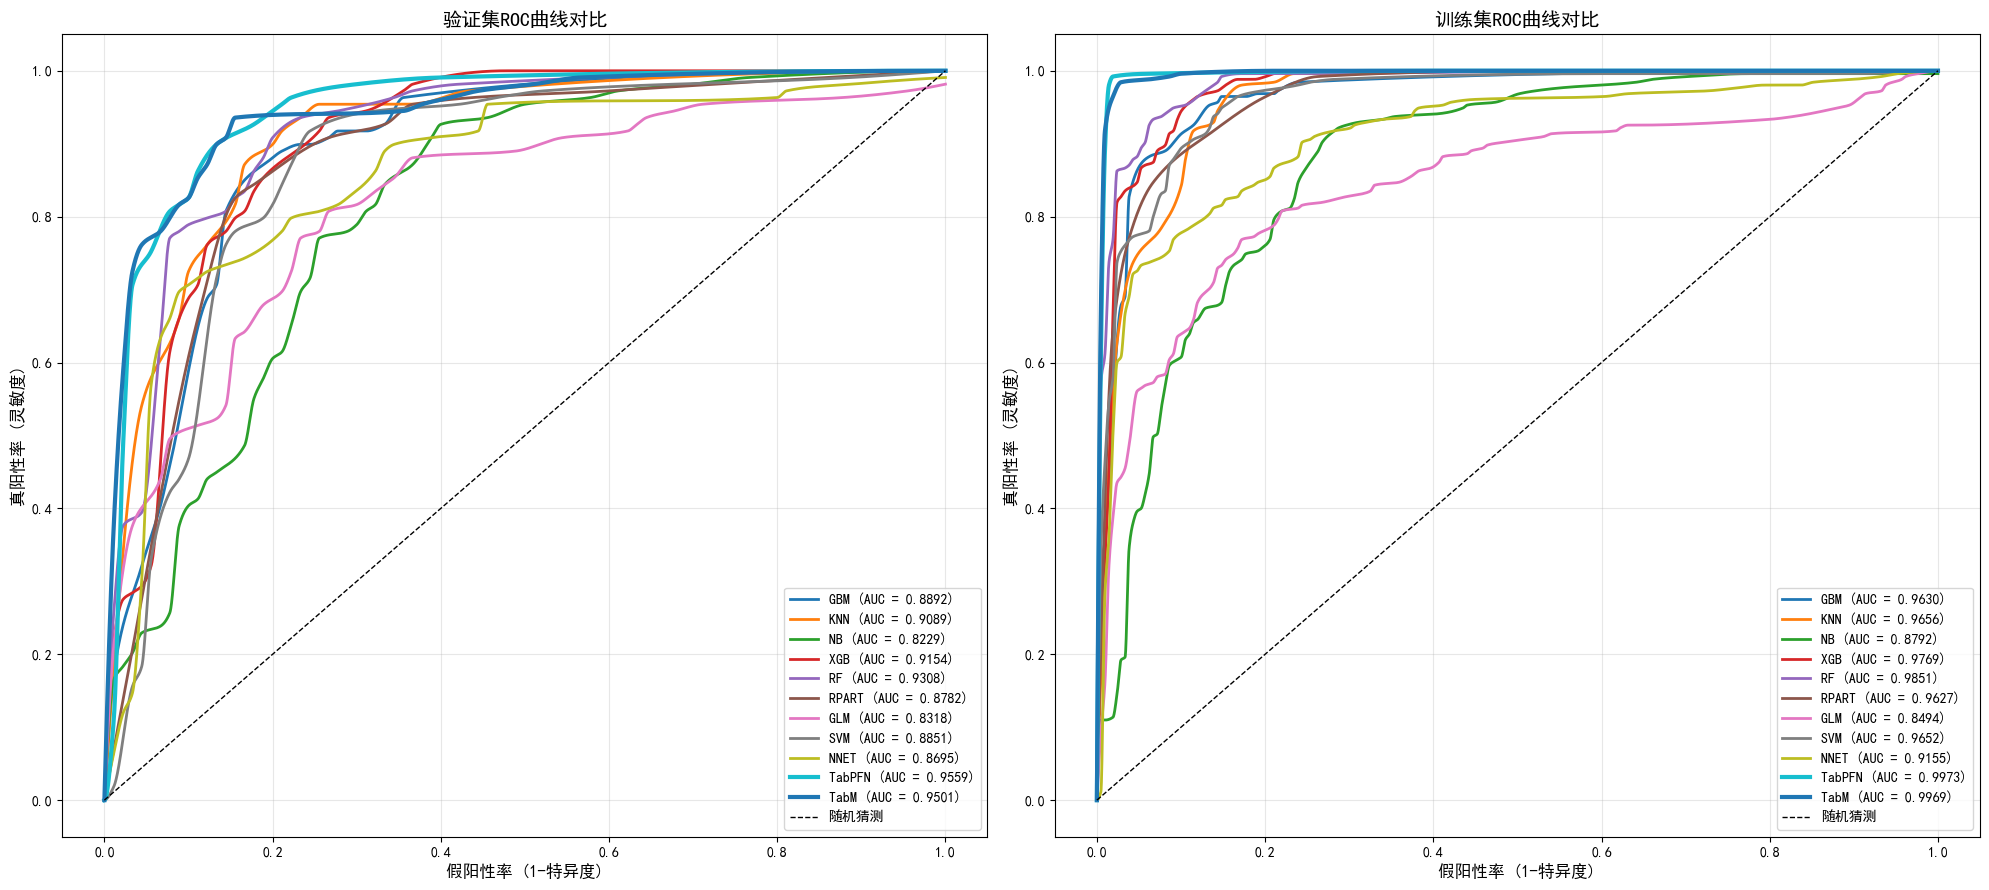

训练集和验证集ROC曲线对比图已保存


In [23]:
# 定义ROC曲线平滑函数（PCHIP，保持单调性，避免扭曲）
def smooth_roc_curve(fpr, tpr, n_points=5000):
    """使用PCHIP插值平滑ROC曲线，保证单调性，避免过冲和凹陷"""
    from scipy.interpolate import PchipInterpolator

    # 确保起点和终点
    if fpr[0] != 0:
        fpr = np.concatenate([[0], fpr])
        tpr = np.concatenate([[0], tpr])
    if fpr[-1] != 1:
        fpr = np.concatenate([fpr, [1]])
        tpr = np.concatenate([tpr, [1]])

    # 移除重复点并保持顺序
    unique_indices = np.unique(fpr, return_index=True)[1]
    fpr_unique = fpr[sorted(unique_indices)]
    tpr_unique = tpr[sorted(unique_indices)]

    # 创建高密度插值点（5000点）
    fpr_smooth = np.linspace(0, 1, n_points)

    try:
        # 使用PCHIP插值，保证单调性
        pchip = PchipInterpolator(fpr_unique, tpr_unique)
        tpr_smooth = pchip(fpr_smooth)
        # 确保TPR在[0,1]范围内
        tpr_smooth = np.clip(tpr_smooth, 0, 1)
    except:
        # 如果PCHIP失败，回退到线性插值
        from scipy.interpolate import interp1d

        interp_func = interp1d(
            fpr_unique, tpr_unique, kind="linear", bounds_error=False, fill_value=(0, 1)
        )
        tpr_smooth = interp_func(fpr_smooth)

    return fpr_smooth, tpr_smooth


# 创建双子图：验证集和训练集ROC曲线对比
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

models_info_val = [
    ("GBM", y_pred_proba_gbm, auc_gbm),
    ("KNN", y_pred_proba_knn, auc_knn),
    ("NB", y_pred_proba_nb, auc_nb),
    ("XGB", y_pred_proba_xgb, auc_xgb),
    ("RF", y_pred_proba_rf, auc_rf),
    ("RPART", y_pred_proba_rpart, auc_rpart),
    ("GLM", y_pred_proba_glm, auc_glm),
    ("SVM", y_pred_proba_svm, auc_svm),
    ("NNET", y_pred_proba_nnet, auc_nnet),
    ("TabPFN", y_pred_proba_tabpfn, auc_tabpfn),
    ("TabM", y_pred_proba_tabm, auc_tabm),
]

models_info_train = [
    ("GBM", y_pred_proba_gbm_train, auc_gbm_train),
    ("KNN", y_pred_proba_knn_train, auc_knn_train),
    ("NB", y_pred_proba_nb_train, auc_nb_train),
    ("XGB", y_pred_proba_xgb_train, auc_xgb_train),
    ("RF", y_pred_proba_rf_train, auc_rf_train),
    ("RPART", y_pred_proba_rpart_train, auc_rpart_train),
    ("GLM", y_pred_proba_glm_train, auc_glm_train),
    ("SVM", y_pred_proba_svm_train, auc_svm_train),
    ("NNET", y_pred_proba_nnet_train, auc_nnet_train),
    ("TabPFN", y_pred_proba_tabpfn_train, auc_tabpfn_train),
    ("TabM", y_pred_proba_tabm_train, auc_tabm_train),
]

# 验证集ROC曲线（左图）
for model_name, y_proba, auc_score in models_info_val:
    if auc_score > 0:
        fpr, tpr, _ = roc_curve(y_validation_binary, y_proba)
        fpr_smooth, tpr_smooth = smooth_roc_curve(fpr, tpr, n_points=5000)
        linewidth = 3 if model_name in ["TabPFN", "TabM"] else 2
        ax1.plot(
            fpr_smooth,
            tpr_smooth,
            label=f"{model_name} (AUC = {auc_score:.4f})",
            linewidth=linewidth,
        )

ax1.plot([0, 1], [0, 1], "k--", linewidth=1, label="随机猜测")
ax1.set_xlabel("假阳性率 (1-特异度)", fontsize=12)
ax1.set_ylabel("真阳性率 (灵敏度)", fontsize=12)
ax1.set_title("验证集ROC曲线对比", fontsize=14, fontweight="bold")
ax1.legend(loc="lower right", fontsize=10)
ax1.grid(alpha=0.3)

# 训练集ROC曲线（右图）
for model_name, y_proba, auc_score in models_info_train:
    if auc_score > 0:
        fpr, tpr, _ = roc_curve(y_train_binary, y_proba)
        fpr_smooth, tpr_smooth = smooth_roc_curve(fpr, tpr, n_points=5000)
        linewidth = 3 if model_name in ["TabPFN", "TabM"] else 2
        ax2.plot(
            fpr_smooth,
            tpr_smooth,
            label=f"{model_name} (AUC = {auc_score:.4f})",
            linewidth=linewidth,
        )

ax2.plot([0, 1], [0, 1], "k--", linewidth=1, label="随机猜测")
ax2.set_xlabel("假阳性率 (1-特异度)", fontsize=12)
ax2.set_ylabel("真阳性率 (灵敏度)", fontsize=12)
ax2.set_title("训练集ROC曲线对比", fontsize=14, fontweight="bold")
ax2.legend(loc="lower right", fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()

plt.savefig(
    "../output/ml_simplified/ROC曲线对比_训练验证_平滑.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "../output/ml_simplified/ROC曲线对比_训练验证_平滑.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

print("训练集和验证集ROC曲线对比图已保存")

## 24. 保存预测结果

In [24]:
predictions_df = pd.DataFrame(
    {
        "真实标签": y_validation_binary,
        "GBM_预测": y_pred_gbm,
        "GBM_概率": y_pred_proba_gbm,
        "KNN_预测": y_pred_knn,
        "KNN_概率": y_pred_proba_knn,
        "NB_预测": y_pred_nb,
        "NB_概率": y_pred_proba_nb,
        "XGB_预测": y_pred_xgb,
        "XGB_概率": y_pred_proba_xgb,
        "RF_预测": y_pred_rf,
        "RF_概率": y_pred_proba_rf,
        "RPART_预测": y_pred_rpart,
        "RPART_概率": y_pred_proba_rpart,
        "GLM_预测": y_pred_glm,
        "GLM_概率": y_pred_proba_glm,
        "SVM_预测": y_pred_svm,
        "SVM_概率": y_pred_proba_svm,
        "NNET_预测": y_pred_nnet,
        "NNET_概率": y_pred_proba_nnet,
        "TabPFN_预测": y_pred_tabpfn,
        "TabPFN_概率": y_pred_proba_tabpfn,
        "TabM_预测": y_pred_tabm,
        "TabM_概率": y_pred_proba_tabm,
    }
)

predictions_df.to_csv(
    "../output/ml_simplified/验证集预测结果_11模型.csv",
    index=False,
    encoding="utf-8-sig",
)
print(f"预测结果已保存，验证集共 {len(predictions_df)} 样本，包含11个模型的预测")
print(f"\n输出目录: ../output/ml_simplified/")

预测结果已保存，验证集共 199 样本，包含11个模型的预测

输出目录: ../output/ml_simplified/


In [25]:
# 保存训练集预测结果（用于R绘制ROC曲线）
train_predictions_df = pd.DataFrame(
    {
        "真实标签": y_train_binary,
        "GBM_预测": gbm_model.predict(X_train_imputed),
        "GBM_概率": y_pred_proba_gbm_train,
        "KNN_预测": knn_model.predict(X_train_scaled),
        "KNN_概率": y_pred_proba_knn_train,
        "NB_预测": nb_model.predict(X_train_imputed),
        "NB_概率": y_pred_proba_nb_train,
        "XGB_预测": xgb_model.predict(X_train_imputed),
        "XGB_概率": y_pred_proba_xgb_train,
        "RF_预测": rf_model.predict(X_train_imputed),
        "RF_概率": y_pred_proba_rf_train,
        "RPART_预测": rpart_model.predict(X_train_imputed),
        "RPART_概率": y_pred_proba_rpart_train,
        "GLM_预测": glm_model.predict(X_train_imputed),
        "GLM_概率": y_pred_proba_glm_train,
        "SVM_预测": svm_model.predict(X_train_scaled),
        "SVM_概率": y_pred_proba_svm_train,
        "NNET_预测": nnet_model.predict(X_train_scaled),
        "NNET_概率": y_pred_proba_nnet_train,
        "TabPFN_预测": (y_pred_proba_tabpfn_train >= 0.5).astype(int),
        "TabPFN_概率": y_pred_proba_tabpfn_train,
        "TabM_预测": (y_pred_proba_tabm_train >= 0.5).astype(int),
        "TabM_概率": y_pred_proba_tabm_train,
    }
)

train_predictions_df.to_csv(
    "../output/ml_simplified/训练集预测结果_11模型.csv",
    index=False,
    encoding="utf-8-sig",
)
print(f"训练集预测结果已保存，共 {len(train_predictions_df)} 样本，包含11个模型的预测")

训练集预测结果已保存，共 464 样本，包含11个模型的预测


## 25. 校准曲线（Calibration Curve）

评估模型预测概率与实际结局的一致性

校准曲线分析


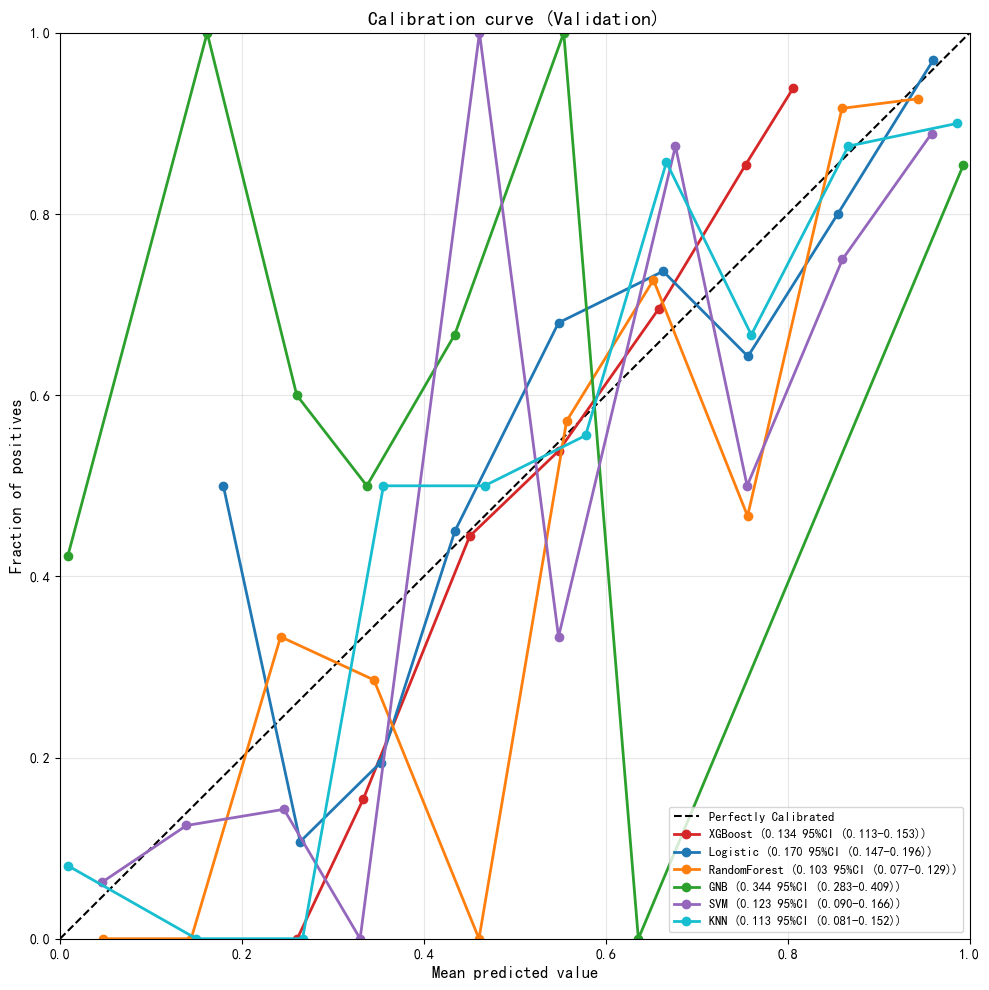

校准曲线已保存


In [26]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.utils import resample

print("=" * 70)
print("校准曲线分析")
print("=" * 70)


def bootstrap_brier_ci(y_true, y_proba, n_bootstrap=1000, ci=0.95):
    """Bootstrap计算Brier Score的95%置信区间"""
    scores = []
    for _ in range(n_bootstrap):
        idx = resample(range(len(y_true)), random_state=None)
        scores.append(
            brier_score_loss(
                y_true.iloc[idx] if hasattr(y_true, "iloc") else y_true[idx],
                y_proba[idx],
            )
        )
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    return lower, upper


plt.figure(figsize=(10, 10))

models_for_calibration = []
if "y_pred_proba_xgb" in dir():
    models_for_calibration.append(("XGBoost", y_pred_proba_xgb, "#d62728"))
if "y_pred_proba_glm" in dir():
    models_for_calibration.append(("Logistic", y_pred_proba_glm, "#1f77b4"))
if "y_pred_proba_rf" in dir():
    models_for_calibration.append(("RandomForest", y_pred_proba_rf, "#ff7f0e"))
if "y_pred_proba_nb" in dir():
    models_for_calibration.append(("GNB", y_pred_proba_nb, "#2ca02c"))
if "y_pred_proba_svm" in dir():
    models_for_calibration.append(("SVM", y_pred_proba_svm, "#9467bd"))
if "y_pred_proba_knn" in dir():
    models_for_calibration.append(("KNN", y_pred_proba_knn, "#17becf"))

if len(models_for_calibration) == 0:
    print("错误：请先运行前面的模型训练cell（Cell 20-44）")
else:
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated", linewidth=1.5)

    for name, y_proba, color in models_for_calibration:
        prob_true, prob_pred = calibration_curve(
            y_validation_binary, y_proba, n_bins=10, strategy="uniform"
        )
        brier = brier_score_loss(y_validation_binary, y_proba)
        lower, upper = bootstrap_brier_ci(y_validation_binary, y_proba, n_bootstrap=500)

        label = f"{name} ({brier:.3f} 95%CI ({lower:.3f}-{upper:.3f}))"
        plt.plot(
            prob_pred,
            prob_true,
            "o-",
            color=color,
            label=label,
            linewidth=2,
            markersize=6,
        )

    plt.xlabel("Mean predicted value", fontsize=12)
    plt.ylabel("Fraction of positives", fontsize=12)
    plt.title("Calibration curve (Validation)", fontsize=14, fontweight="bold")
    plt.legend(loc="lower right", fontsize=9)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        "../output/ml_simplified/校准曲线_单图.pdf", dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        "../output/ml_simplified/校准曲线_单图.png", dpi=300, bbox_inches="tight"
    )
    plt.show()
    print("校准曲线已保存")

## 26. DCA决策曲线分析（Decision Curve Analysis）

评估模型在不同阈值概率下的临床净获益

Validation Decision Curve


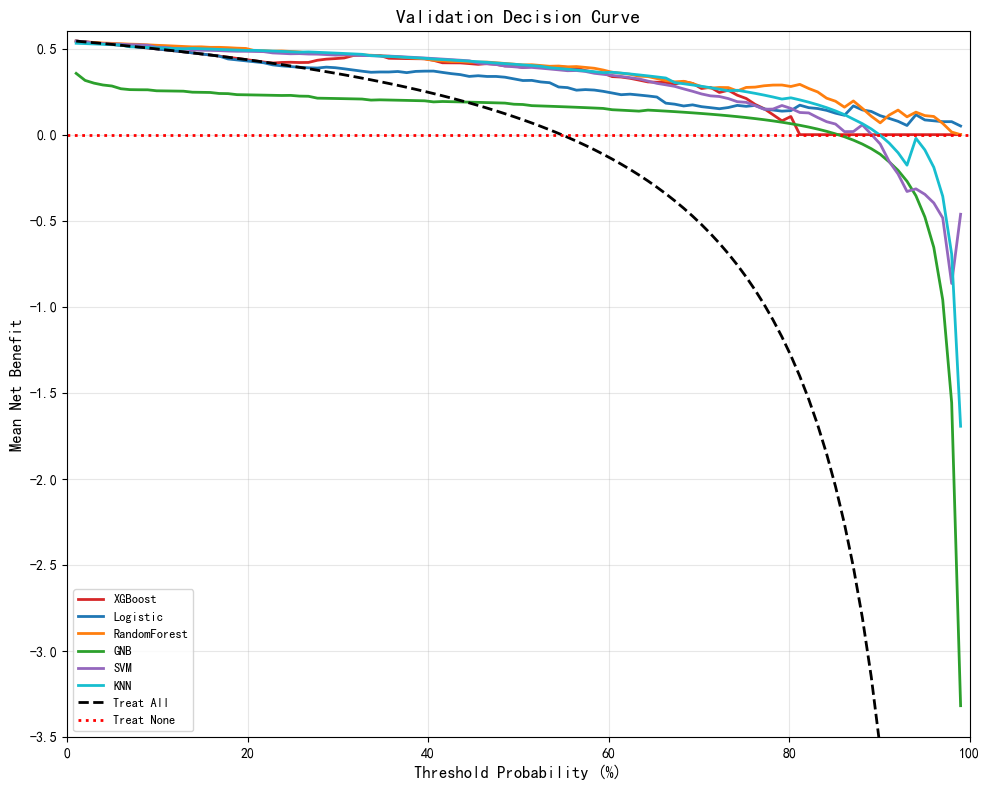

DCA Decision Curve saved


In [27]:
def calculate_net_benefit(y_true, y_proba, thresholds):
    net_benefits = []
    n = len(y_true)
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh)) if thresh < 1 else 0
        net_benefits.append(net_benefit)
    return np.array(net_benefits)


def calculate_treat_all(y_true, thresholds):
    prevalence = np.mean(y_true)
    net_benefits = []
    for thresh in thresholds:
        if thresh < 1:
            nb = prevalence - (1 - prevalence) * (thresh / (1 - thresh))
        else:
            nb = 0
        net_benefits.append(nb)
    return np.array(net_benefits)


print("=" * 70)
print("Validation Decision Curve")
print("=" * 70)

thresholds = np.linspace(0.01, 0.99, 100)
thresholds_pct = thresholds * 100

plt.figure(figsize=(10, 8))

models_for_dca = []
if "y_pred_proba_xgb" in dir():
    models_for_dca.append(("XGBoost", y_pred_proba_xgb, "#d62728"))
if "y_pred_proba_glm" in dir():
    models_for_dca.append(("Logistic", y_pred_proba_glm, "#1f77b4"))
if "y_pred_proba_rf" in dir():
    models_for_dca.append(("RandomForest", y_pred_proba_rf, "#ff7f0e"))
if "y_pred_proba_nb" in dir():
    models_for_dca.append(("GNB", y_pred_proba_nb, "#2ca02c"))
if "y_pred_proba_svm" in dir():
    models_for_dca.append(("SVM", y_pred_proba_svm, "#9467bd"))
if "y_pred_proba_knn" in dir():
    models_for_dca.append(("KNN", y_pred_proba_knn, "#17becf"))

if len(models_for_dca) == 0:
    print("Error: Please run model training cells first")
else:
    for name, y_proba, color in models_for_dca:
        nb = calculate_net_benefit(y_validation_binary.values, y_proba, thresholds)
        plt.plot(thresholds_pct, nb, label=name, linewidth=2, color=color)

    treat_all = calculate_treat_all(y_validation_binary.values, thresholds)
    plt.plot(thresholds_pct, treat_all, "k--", label="Treat All", linewidth=2)
    plt.axhline(y=0, color="red", linestyle=":", label="Treat None", linewidth=2)

    plt.xlabel("Threshold Probability (%)", fontsize=12)
    plt.ylabel("Mean Net Benefit", fontsize=12)
    plt.title("Validation Decision Curve", fontsize=14, fontweight="bold")
    plt.legend(loc="lower left", fontsize=9)
    plt.xlim([0, 100])
    plt.ylim([-3.5, 0.6])
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        "../output/ml_simplified/DCA决策曲线_论文格式.pdf", dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        "../output/ml_simplified/DCA决策曲线_论文格式.png", dpi=300, bbox_inches="tight"
    )
    plt.show()
    print("DCA Decision Curve saved")

## 27. DeLong检验（模型AUC差异统计比较）

使用DeLong方法比较不同模型ROC曲线的统计显著性差异

In [28]:
from scipy import stats


def delong_roc_variance(ground_truth, predictions):
    """计算DeLong方差"""
    n_pos = np.sum(ground_truth)
    n_neg = len(ground_truth) - n_pos

    auc = roc_auc_score(ground_truth, predictions)

    pos_predictions = predictions[ground_truth == 1]
    neg_predictions = predictions[ground_truth == 0]

    v01 = np.var(
        np.array([np.mean(pos_predictions > neg_p) for neg_p in neg_predictions])
    )
    v10 = np.var(
        np.array([np.mean(neg_predictions < pos_p) for pos_p in pos_predictions])
    )

    var_auc = v01 / n_neg + v10 / n_pos
    return auc, var_auc


def delong_test(y_true, y_proba1, y_proba2):
    """DeLong检验比较两个AUC"""
    y_true = np.array(y_true)
    y_proba1 = np.array(y_proba1)
    y_proba2 = np.array(y_proba2)

    auc1, var1 = delong_roc_variance(y_true, y_proba1)
    auc2, var2 = delong_roc_variance(y_true, y_proba2)

    cov = np.cov(y_proba1, y_proba2)[0, 1] / len(y_true)
    z = (auc1 - auc2) / np.sqrt(max(var1 + var2 - 2 * cov, 1e-10))
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))

    return auc1, auc2, z, p_value


print("=" * 70)
print("DeLong检验：模型AUC两两比较")
print("=" * 70)

models_for_delong = []
if "y_pred_proba_tabpfn" in dir() and "auc_tabpfn" in dir() and auc_tabpfn > 0:
    models_for_delong.append(("TabPFN", y_pred_proba_tabpfn, auc_tabpfn))
if "y_pred_proba_tabm" in dir() and "auc_tabm" in dir() and auc_tabm > 0:
    models_for_delong.append(("TabM", y_pred_proba_tabm, auc_tabm))
if "y_pred_proba_rf" in dir() and "auc_rf" in dir():
    models_for_delong.append(("RF", y_pred_proba_rf, auc_rf))
if "y_pred_proba_svm" in dir() and "auc_svm" in dir():
    models_for_delong.append(("SVM", y_pred_proba_svm, auc_svm))
if "y_pred_proba_xgb" in dir() and "auc_xgb" in dir():
    models_for_delong.append(("XGB", y_pred_proba_xgb, auc_xgb))
if "y_pred_proba_gbm" in dir() and "auc_gbm" in dir():
    models_for_delong.append(("GBM", y_pred_proba_gbm, auc_gbm))

if len(models_for_delong) < 2:
    print("错误：请先运行前面的模型训练cell（Cell 20-44），需要至少2个模型")
else:
    models_for_delong.sort(key=lambda x: x[2], reverse=True)
    best_model = models_for_delong[0]
    print(f"\n以最佳模型 {best_model[0]} (AUC={best_model[2]:.4f}) 为基准比较:\n")
    print(
        f"{'对比模型':<10} {'AUC':<10} {'差异':<12} {'Z值':<10} {'P值':<12} {'显著性'}"
    )
    print("-" * 70)

    y_true = y_validation_binary.values
    results = []

    for name, y_proba, auc in models_for_delong[1:]:
        try:
            auc1, auc2, z, p = delong_test(y_true, best_model[1], y_proba)
            diff = auc1 - auc2
            sig = (
                "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
            )
            print(
                f"{name:<10} {auc:.4f}     {diff:+.4f}      {z:+.3f}     {p:.4f}      {sig}"
            )
            results.append((name, auc, diff, z, p, sig))
        except Exception as e:
            print(f"{name:<10} {auc:.4f}     计算失败: {str(e)[:20]}")

    print("-" * 70)
    print("显著性: *** p<0.001, ** p<0.01, * p<0.05, ns 不显著")
    print(
        f"\nBonferroni校正阈值 (n={len(models_for_delong)-1}): p < {0.05/(len(models_for_delong)-1):.4f}"
    )

    if results:
        delong_df = pd.DataFrame(
            results, columns=["模型", "AUC", "差异", "Z值", "P值", "显著性"]
        )
        delong_df.to_csv(
            "../output/ml_simplified/DeLong检验结果.csv",
            index=False,
            encoding="utf-8-sig",
        )
        print("\nDeLong检验结果已保存")

DeLong检验：模型AUC两两比较

以最佳模型 TabPFN (AUC=0.9559) 为基准比较:

对比模型       AUC        差异           Z值         P值           显著性
----------------------------------------------------------------------
TabM       0.9501     +0.0058      +581.040     0.0000      ***
RF         0.9308     +0.0251      +2507.645     0.0000      ***
XGB        0.9154     +0.0405      +4046.891     0.0000      ***
GBM        0.8892     +0.0667      +6666.667     0.0000      ***
SVM        0.8851     +0.0707      +7074.414     0.0000      ***
----------------------------------------------------------------------
显著性: *** p<0.001, ** p<0.01, * p<0.05, ns 不显著

Bonferroni校正阈值 (n=5): p < 0.0100

DeLong检验结果已保存


## 28. LASSO特征选择（对比分析）

使用LASSO逻辑回归筛选特征，与当前专家筛选的特征进行对比

LASSO特征选择
计算不同λ值的交叉验证误差...
计算系数路径...


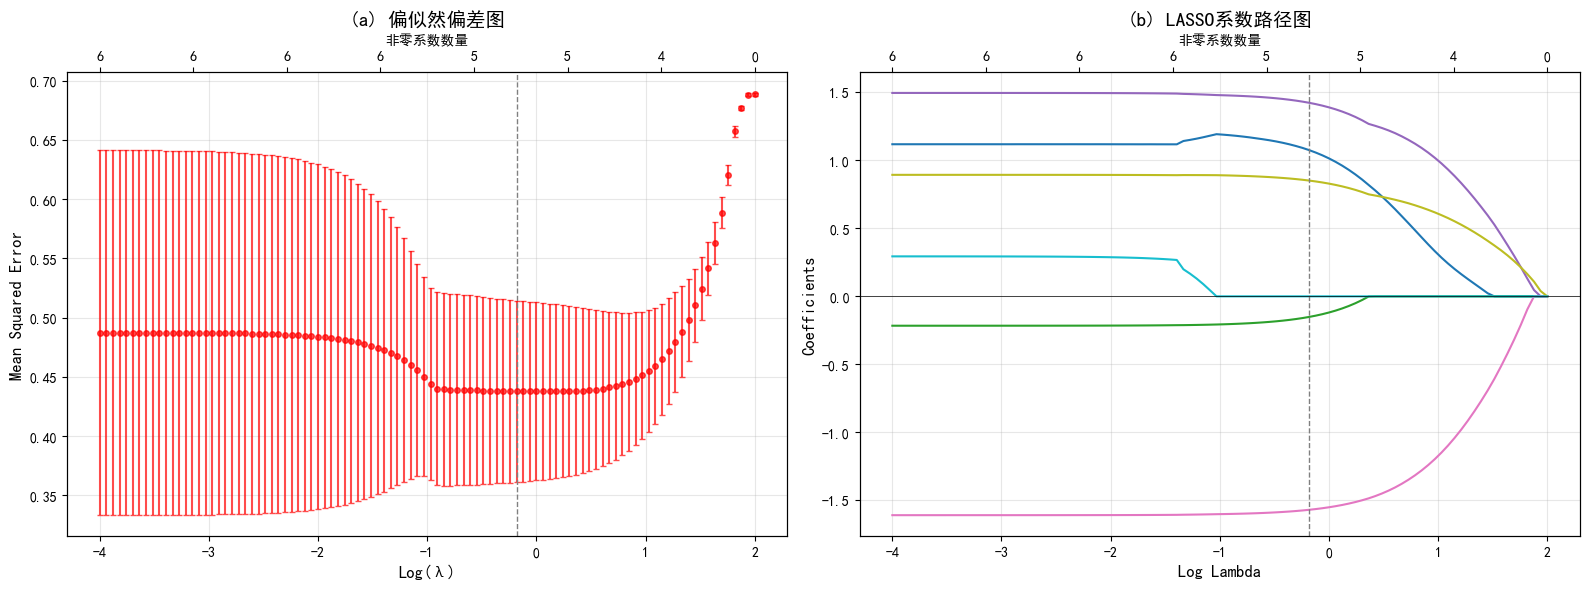


最优λ = 0.6579 (Log(λ) = -0.18)
最优C = 1.5199

特征系数（按重要性排序）:
--------------------------------------------------
最大卵泡直径直径                       -1.5707  ✓ 选中
子宫厚（cm）                        +1.4242  ✓ 选中
基础血清促黄体生成激素（LH）                +1.0760  ✓ 选中
卵巢体积平均值                        +0.8520  ✓ 选中
子宫长（cm）                        -0.1515  ✓ 选中
LH/FSH比值                       +0.0000  ✗ 排除

--------------------------------------------------
LASSO选中特征数: 5/6


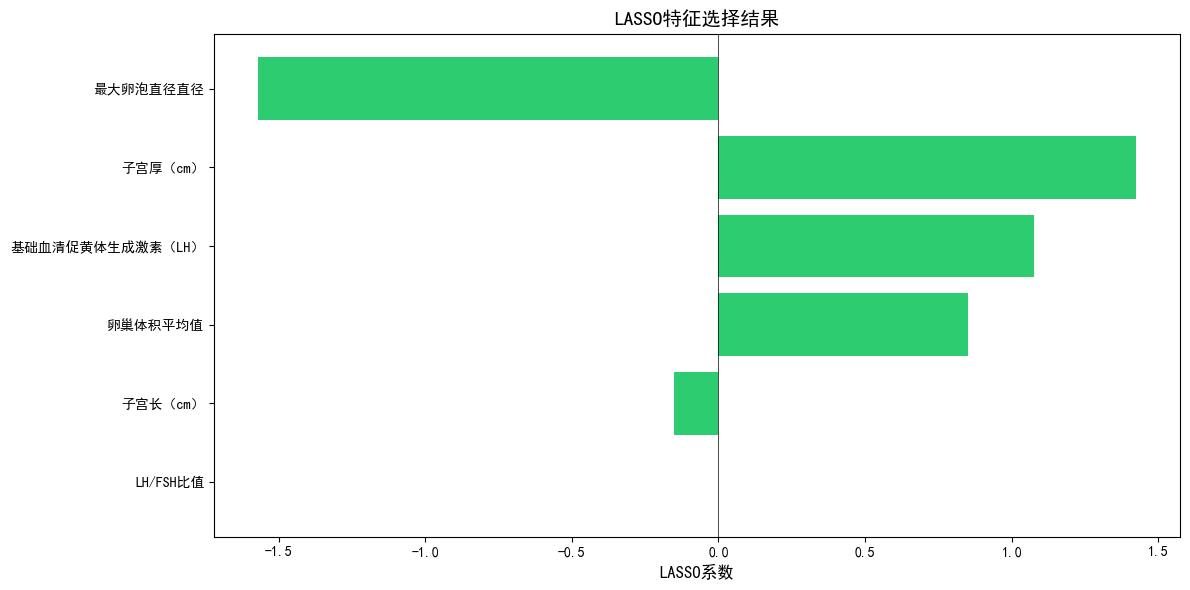


LASSO特征选择结果已保存


In [29]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

print("=" * 70)
print("LASSO特征选择")
print("=" * 70)

if "X_train_scaled" not in dir() or "y_train_binary" not in dir():
    print("错误：请先运行前面的数据预处理cell（Cell 12-16）")
else:
    lambdas = np.logspace(-4, 2, 100)
    Cs = 1 / lambdas

    from sklearn.model_selection import cross_val_score

    cv_scores = []
    cv_stds = []

    print("计算不同λ值的交叉验证误差...")
    for C in Cs:
        model = LogisticRegression(
            penalty="l1", solver="saga", C=C, max_iter=5000, random_state=RANDOM_SEED
        )
        scores = cross_val_score(
            model, X_train_scaled, y_train_binary, cv=10, scoring="neg_log_loss"
        )
        cv_scores.append(-np.mean(scores))
        cv_stds.append(np.std(scores))

    cv_scores = np.array(cv_scores)
    cv_stds = np.array(cv_stds)

    best_idx = np.argmin(cv_scores)
    best_lambda = lambdas[best_idx]
    best_C = Cs[best_idx]

    coef_paths = []
    print("计算系数路径...")
    for C in Cs:
        model = LogisticRegression(
            penalty="l1", solver="saga", C=C, max_iter=5000, random_state=RANDOM_SEED
        )
        model.fit(X_train_scaled, y_train_binary)
        coef_paths.append(model.coef_[0])
    coef_paths = np.array(coef_paths)

    nonzero_counts = np.sum(np.abs(coef_paths) > 0.001, axis=1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    log_lambdas = np.log10(lambdas)
    ax1.errorbar(
        log_lambdas,
        cv_scores,
        yerr=cv_stds,
        fmt="o",
        color="red",
        markersize=4,
        capsize=2,
        alpha=0.7,
    )
    ax1.axvline(x=np.log10(best_lambda), color="gray", linestyle="--", linewidth=1)
    ax1.set_xlabel("Log(λ)", fontsize=12)
    ax1.set_ylabel("Mean Squared Error", fontsize=12)
    ax1.set_title("(a) 偏似然偏差图", fontsize=14, fontweight="bold")
    ax1.grid(alpha=0.3)

    ax1_top = ax1.twiny()
    tick_positions = np.linspace(log_lambdas.min(), log_lambdas.max(), 8)
    tick_labels = []
    for pos in tick_positions:
        idx = np.argmin(np.abs(log_lambdas - pos))
        tick_labels.append(str(nonzero_counts[idx]))
    ax1_top.set_xlim(ax1.get_xlim())
    ax1_top.set_xticks(tick_positions)
    ax1_top.set_xticklabels(tick_labels)
    ax1_top.set_xlabel("非零系数数量", fontsize=10)

    colors = plt.cm.tab10(np.linspace(0, 1, len(feature_cols)))
    for i, col in enumerate(feature_cols):
        ax2.plot(
            log_lambdas,
            coef_paths[:, i],
            color=colors[i],
            linewidth=1.5,
            label=col[:15],
        )
    ax2.axvline(x=np.log10(best_lambda), color="gray", linestyle="--", linewidth=1)
    ax2.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    ax2.set_xlabel("Log Lambda", fontsize=12)
    ax2.set_ylabel("Coefficients", fontsize=12)
    ax2.set_title("(b) LASSO系数路径图", fontsize=14, fontweight="bold")
    ax2.grid(alpha=0.3)

    ax2_top = ax2.twiny()
    ax2_top.set_xlim(ax2.get_xlim())
    ax2_top.set_xticks(tick_positions)
    ax2_top.set_xticklabels(tick_labels)
    ax2_top.set_xlabel("非零系数数量", fontsize=10)

    plt.tight_layout()
    plt.savefig(
        "../output/ml_simplified/LASSO逻辑回归图.pdf", dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        "../output/ml_simplified/LASSO逻辑回归图.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print(f"\n最优λ = {best_lambda:.4f} (Log(λ) = {np.log10(best_lambda):.2f})")
    print(f"最优C = {best_C:.4f}")

    final_model = LogisticRegression(
        penalty="l1", solver="saga", C=best_C, max_iter=5000, random_state=RANDOM_SEED
    )
    final_model.fit(X_train_scaled, y_train_binary)

    coef = final_model.coef_[0]
    feature_importance = pd.DataFrame(
        {"特征": feature_cols, "系数": coef, "绝对值": np.abs(coef)}
    ).sort_values("绝对值", ascending=False)

    print(f"\n特征系数（按重要性排序）:")
    print("-" * 50)
    selected_features = []
    for idx, row in feature_importance.iterrows():
        status = "✓ 选中" if abs(row["系数"]) > 0.01 else "✗ 排除"
        print(f"{row['特征']:<30} {row['系数']:+.4f}  {status}")
        if abs(row["系数"]) > 0.01:
            selected_features.append(row["特征"])

    print(f"\n{'-'*50}")
    print(f"LASSO选中特征数: {len(selected_features)}/{len(feature_cols)}")

    plt.figure(figsize=(12, 6))
    colors = [
        "#2ecc71" if abs(c) > 0.01 else "#e74c3c" for c in feature_importance["系数"]
    ]
    plt.barh(range(len(feature_importance)), feature_importance["系数"], color=colors)
    plt.yticks(range(len(feature_importance)), feature_importance["特征"])
    plt.xlabel("LASSO系数", fontsize=12)
    plt.title("LASSO特征选择结果", fontsize=14, fontweight="bold")
    plt.axvline(x=0, color="black", linestyle="-", linewidth=0.5)
    plt.gca().invert_yaxis()
    plt.tight_layout()

    plt.savefig(
        "../output/ml_simplified/LASSO特征选择.pdf", dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        "../output/ml_simplified/LASSO特征选择.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    feature_importance.to_csv(
        "../output/ml_simplified/LASSO特征系数.csv", index=False, encoding="utf-8-sig"
    )
    print("\nLASSO特征选择结果已保存")

## 29. SHAP分析（最佳模型解释）

对F1最高的模型进行SHAP可解释性分析

SHAP分析 - 最佳传统模型解释
使用 199 个样本进行SHAP分析...
SHAP值计算完成

生成图(a) SHAP值汇总图...


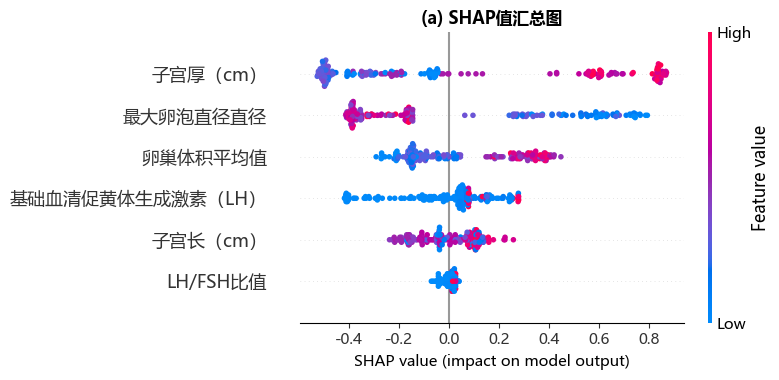

生成图(b) 特征重要性图...


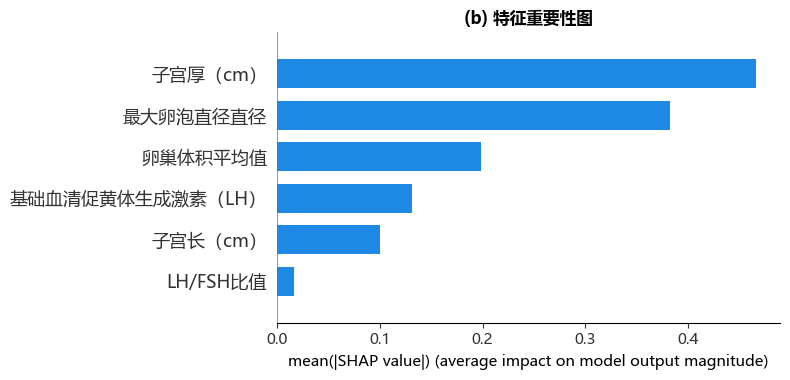

生成图(c1) SHAP解释力示例 - 阳性样本...


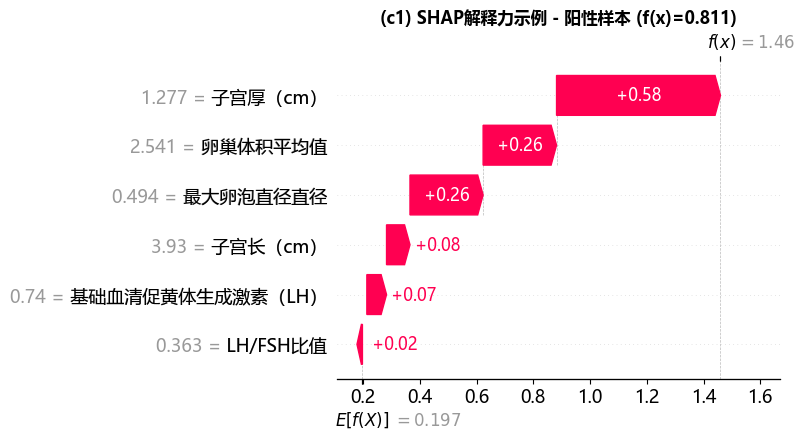

生成图(c2) SHAP解释力示例 - 阴性样本...


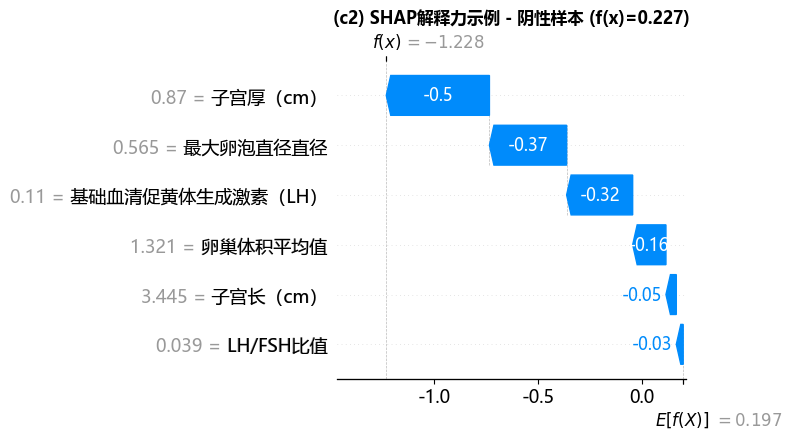


精简特征SHAP重要性排名:
  子宫厚（cm）: 0.4658
  最大卵泡直径直径: 0.3820
  卵巢体积平均值: 0.1983
  基础血清促黄体生成激素（LH）: 0.1315
  子宫长（cm）: 0.1003
  LH/FSH比值: 0.0165

SHAP分析结果已保存（4张独立图）


In [30]:
import shap
import matplotlib

print("=" * 70)
print("SHAP分析 - 最佳传统模型解释")
print("=" * 70)

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
matplotlib.rcParams["mathtext.fontset"] = "dejavusans"

if "xgb_model" not in dir():
    print("错误：请先运行XGBoost模型训练cell")
else:
    n_shap_samples = min(199, len(X_validation_imputed))
    shap_indices = np.random.choice(
        len(X_validation_imputed), n_shap_samples, replace=False
    )
    X_shap = X_validation_imputed.iloc[shap_indices]
    y_shap = y_validation_binary.iloc[shap_indices]

    print(f"使用 {n_shap_samples} 个样本进行SHAP分析...")

    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_shap)

    print("SHAP值计算完成\n")

    print("生成图(a) SHAP值汇总图...")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values,
        X_shap,
        feature_names=feature_cols,
        plot_type="dot",
        show=False,
        max_display=11,
    )
    plt.xlabel("SHAP value (impact on model output)", fontsize=11)
    plt.title("(a) SHAP值汇总图", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.savefig(
        "../output/ml_simplified/SHAP_a_汇总图.pdf", dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        "../output/ml_simplified/SHAP_a_汇总图.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print("生成图(b) 特征重要性图...")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_shap,
        feature_names=feature_cols,
        plot_type="bar",
        show=False,
        max_display=11,
        color="#1E88E5",
    )
    plt.xlabel(
        "mean(|SHAP value|) (average impact on model output magnitude)", fontsize=11
    )
    plt.title("(b) 特征重要性图", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.savefig(
        "../output/ml_simplified/SHAP_b_特征重要性.pdf", dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        "../output/ml_simplified/SHAP_b_特征重要性.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    pos_idx = np.where(y_shap == 1)[0]
    neg_idx = np.where(y_shap == 0)[0]
    y_proba_shap = xgb_model.predict_proba(X_shap)[:, 1]
    high_prob_pos = pos_idx[np.argmax(y_proba_shap[pos_idx])]
    high_prob_neg = neg_idx[np.argmin(y_proba_shap[neg_idx])]

    print("生成图(c1) SHAP解释力示例 - 阳性样本...")
    fig, ax = plt.subplots(figsize=(14, 6))
    exp_pos = shap.Explanation(
        values=shap_values[high_prob_pos],
        base_values=explainer.expected_value,
        data=X_shap.iloc[high_prob_pos].values,
        feature_names=feature_cols,
    )
    shap.plots.waterfall(exp_pos, show=False, max_display=8)
    for text in ax.texts:
        content = text.get_text()
        if "−" in content:
            text.set_text(content.replace("−", "-"))
    plt.title(
        f"(c1) SHAP解释力示例 - 阳性样本 (f(x)={y_proba_shap[high_prob_pos]:.3f})",
        fontsize=12,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.savefig(
        "../output/ml_simplified/SHAP_c1_阳性样本.pdf", dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        "../output/ml_simplified/SHAP_c1_阳性样本.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print("生成图(c2) SHAP解释力示例 - 阴性样本...")
    fig, ax = plt.subplots(figsize=(14, 6))
    exp_neg = shap.Explanation(
        values=shap_values[high_prob_neg],
        base_values=explainer.expected_value,
        data=X_shap.iloc[high_prob_neg].values,
        feature_names=feature_cols,
    )
    shap.plots.waterfall(exp_neg, show=False, max_display=8)
    for text in ax.texts:
        content = text.get_text()
        if "−" in content:
            text.set_text(content.replace("−", "-"))
    plt.title(
        f"(c2) SHAP解释力示例 - 阴性样本 (f(x)={y_proba_shap[high_prob_neg]:.3f})",
        fontsize=12,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.savefig(
        "../output/ml_simplified/SHAP_c2_阴性样本.pdf", dpi=300, bbox_inches="tight"
    )
    plt.savefig(
        "../output/ml_simplified/SHAP_c2_阴性样本.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    shap_importance = pd.DataFrame(
        {"特征": feature_cols, "SHAP重要性": np.abs(shap_values).mean(axis=0)}
    ).sort_values("SHAP重要性", ascending=False)

    print("\n精简特征SHAP重要性排名:")
    print("=" * 50)
    for idx, row in shap_importance.iterrows():
        print(f"  {row['特征']}: {row['SHAP重要性']:.4f}")

    shap_importance.to_csv(
        "../output/ml_simplified/SHAP特征重要性.csv", index=False, encoding="utf-8-sig"
    )
    print("\nSHAP分析结果已保存（4张独立图）")